# PyTorch Classification Model

In [1]:
#!pip install pytorch_lightning
#!pip install lightning

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as torch_optim
import torch.nn.functional as F
import pytorch_lightning as pl
from torch.utils.data import DataLoader,Dataset
from torchmetrics import Accuracy

from sklearn.preprocessing import MinMaxScaler,OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import (accuracy_score,classification_report,
                            confusion_matrix, ConfusionMatrixDisplay,
                            roc_auc_score)
from time import time
import os


## Setup

In [3]:
class OutletBiasDataset(Dataset):
    """
    Dataset class for PyTorch's, allowing us to work with the csv dataset.
    
    From the docs:
    All datasets that represent a map from keys to data samples should subclass it. 
    All subclasses should overwrite __getitem__(), supporting fetching a data sample 
    for a given key. Subclasses could also optionally overwrite __len__(), which is 
    expected to return the size of the dataset by many Sampler implementations and 
    the default options of DataLoader.
    
    """
    def __init__(self, data, numer_cols, label_col):
        data = data.copy()
        #numerical columns
        self.X_num = data.loc[:,numer_cols].copy().values.astype(np.float32)
        #categorical columns
        self.y = data[label_col]
        self.index = data.index

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        return self.index[idx], self.X_num[idx], self.y[idx]

In [4]:
class TabularDataModule(pl.LightningDataModule):
    """
    The Pytorch DataModule enables reusing classes, while incorporating
    all preprocessing steps: making datasets into OutletBiasDataset class instances.
    The DataLoaders are also made here, as required by PyTorch and PyTorch Lightning
    """

    def __init__(self, datadir, dataset_extension,
                 num_cols, label_col, num_workers=2,
                 batch_size_train=16, batch_size_val=16, batch_size_test=16):
        
        super().__init__()
        os.chdir(datadir)
        # datasets
        self.train = pd.read_csv("train{}.csv".format(dataset_extension))
        self.train.set_index("outlet", inplace=True)
        
        self.val = pd.read_csv("val{}.csv".format(dataset_extension))
        self.val.set_index("outlet", inplace=True)
        
        self.test = pd.read_csv("test{}.csv".format(dataset_extension))
        self.test.set_index("outlet", inplace=True)
        
        # define other variables
        self.num_cols = num_cols
        self.label_col = label_col
        self.num_workers = num_workers
        self.batch_size_train = batch_size_train
        self.batch_size_val = batch_size_val
        self.batch_size_test = batch_size_test

    def setup(self, stage=""):
        # check dataset shapes
        print('Train set shape: ', self.train.shape)
        print('Validation set shape: ', self.val.shape)
        print('Test set shape: ', self.test.shape)
        
        # MAKE INTO DATASET FORMAT
        self.dataset_train = OutletBiasDataset(self.train,
                                               self.num_cols,self.label_col)
        self.dataset_val = OutletBiasDataset(self.val,
                                               self.num_cols,self.label_col)
        self.dataset_test = OutletBiasDataset(self.test,
                                               self.num_cols,self.label_col)

    def train_dataloader(self):
        return DataLoader(
            self.dataset_train,
            num_workers=self.num_workers,
            batch_size=self.batch_size_train,
            shuffle=True
        )

    def val_dataloader(self):
        return DataLoader(
            self.dataset_val,
            num_workers=self.num_workers,
            batch_size=self.batch_size_val,
            shuffle=False
        )

    def test_dataloader(self):
        return DataLoader(
            self.dataset_test,
            num_workers=self.num_workers,
            batch_size=self.batch_size_test,
            shuffle=False
        )

In [5]:
class TabularNetModel(pl.LightningModule):
    """
    Model class in PyTorch Lightning. Model structure is defined in self.layers().
    
    Initialize with:
    - num_cols: columns in dataset that are numeric,
    - embedding_size_dict: predetermined embedding sizes per categorical feature,
    - n_classes: number of classes to be classified,
    - learning_rate: model's learning rate,
    - neurons_per_layer_list: list of neurons to be put per layer, for any number of layers,
    - dropout_p: dropout probability between each layer
    
    """
    def __init__(self, num_cols, n_classes,
                 neurons_per_layer_list=[512,256,128],
                 learning_rate=0.001, dropout_p=0.2):
        super().__init__()
        
        # pytorch lightning black magic, all the arguments can now be
        # accessed through self.hparams.[argument]
        self.save_hyperparameters()
        self.num_cols = num_cols
        self.num_len = len(num_cols)
        self.n_classes = n_classes
        
        # get number of input features for model
        in_features = self.num_len
        
        # let's finally define the model architecture itself:
        all_layers = []
        for i in neurons_per_layer_list:
            all_layers.append(nn.Linear(in_features, i))
            all_layers.append(nn.ReLU(inplace=True))
            all_layers.append(nn.BatchNorm1d(i))
            all_layers.append(nn.Dropout(dropout_p))
            in_features = i
            
        # add final output layer,
        all_layers.append(nn.Linear(neurons_per_layer_list[-1], n_classes))
        # and put into Sequantial.
        self.layers = nn.Sequential(*all_layers)
        
        # something to keep track of accuracy with...
        self.val_accuracy = Accuracy(task="multiclass", num_classes=self.n_classes)
        self.test_accuracy = Accuracy(task="multiclass", num_classes=self.n_classes)

    def forward(self, num_tensor):
        # concatenate the categorical embedding and numerical layer
        #all_outputs = torch.cat((num_tensor, cat_outputs), dim=1)
        
        # now we get the final outputs through the layers we made earlier
        final_outputs = self.layers(num_tensor).squeeze(dim=1)
        
        return F.log_softmax(final_outputs, dim=1)

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), 
                                lr=self.hparams.learning_rate)
    
    def training_step(self, batch, batch_idx):
        index, num_tensor, label_tensor = batch
        output_tensor = self(num_tensor)
        # compute loss
        loss = F.nll_loss(output_tensor, label_tensor)
        self.log('train_loss', loss, prog_bar=True)
        return loss

    def validation_step(self, batch, batch_idx):
        index, num_tensor, label_tensor = batch
        output_tensor = self(num_tensor)
        # compute loss
        loss = F.nll_loss(output_tensor, label_tensor)
        self.log("val_loss", loss, prog_bar=True)
        # compute accuracy
        preds = torch.argmax(output_tensor, dim=1)
        self.val_accuracy.update(preds, label_tensor)
        self.log("val_acc", self.val_accuracy, prog_bar=True)

    def test_step(self, batch, batch_idx):
        index, num_tensor,label_tensor = batch
        output_tensor = self(num_tensor)
        # compute loss
        loss = F.nll_loss(output_tensor, label_tensor)
        self.log('test_loss', loss, prog_bar=True)
        # compute accuracy
        preds = torch.argmax(output_tensor, dim=1)
        self.val_accuracy.update(preds, label_tensor)
        self.log("test_acc", self.val_accuracy, prog_bar=True)


## Main

In [6]:
#------------------------------------------------------------------------------
# IMPORT DATA FOR MAKING CUSTOM EMBEDDINGS
#------------------------------------------------------------------------------
# make list of class names in correct order
global class_names
class_names = ["left","left center","least biased","right center","right"] #["left","center","right"]# in order from MBFC mappings

dataset_extension = "_mbfc_allbias"

data = pd.read_csv("GDELT_GKG/data/train{}.csv".format(dataset_extension))
data.set_index("outlet", inplace=True)

#------------------------------------------------------------------------------
# GET CATEGORICAL FEATURES TO EMBED AND DETERMINE EMBEDDING SIZES
#------------------------------------------------------------------------------

# get categorical and numerical columns
label_col = "lean"
num_cols = data.columns.difference([label_col])


In [7]:
#------------------------------------------------------------------------------
# MAKE DATASET MODULE
#------------------------------------------------------------------------------

tabular_data_module = TabularDataModule("GDELT_GKG/data", 
                                        dataset_extension=dataset_extension,
                                        num_cols=num_cols, label_col=label_col, 
                                        num_workers=2,
                                        batch_size_train=32, 
                                        batch_size_val=32, 
                                        batch_size_test=32)

In [8]:
#------------------------------------------------------------------------------
# MAKE MODEL(S)
#------------------------------------------------------------------------------

# we can print out the network architecture for inspection
tabular_model = TabularNetModel(num_cols,n_classes=len(class_names),neurons_per_layer_list = [512,256], dropout_p=0.5)
# for viewing architecture:
tabular_model

TabularNetModel(
  (layers): Sequential(
    (0): Linear(in_features=357, out_features=512, bias=True)
    (1): ReLU(inplace=True)
    (2): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Dropout(p=0.5, inplace=False)
    (4): Linear(in_features=512, out_features=256, bias=True)
    (5): ReLU(inplace=True)
    (6): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): Dropout(p=0.5, inplace=False)
    (8): Linear(in_features=256, out_features=5, bias=True)
  )
  (val_accuracy): MulticlassAccuracy()
  (test_accuracy): MulticlassAccuracy()
)

In [9]:
#------------------------------------------------------------------------------
# MODEL TRAINING
#------------------------------------------------------------------------------

from pytorch_lightning.callbacks import (EarlyStopping,LearningRateFinder,ModelCheckpoint)

callbacks = [EarlyStopping(monitor='val_acc', 
                           min_delta=0.005, 
                           patience=10,
                           mode="max"),
             # finds optimal learning rate automatically
             LearningRateFinder(min_lr=1e-08, 
                               max_lr=1, 
                               num_training_steps=100, 
                               mode='exponential', 
                               early_stop_threshold=4.0),
            # saves top-K checkpoints based on "val_acc" metric
            ModelCheckpoint(
                save_top_k=5,
                monitor="val_acc",
                mode="max",
                dirpath="lightning_logs/",
                filename="TabularModel-{epoch:02d}-{val_acc:.2f}",
            )]

trainer = pl.Trainer(max_epochs=100, 
                     min_epochs=5,
                     callbacks=callbacks,
                     logger=True,
                     log_every_n_steps=10,
                     #enable_checkpointing=True
                    )

trainer.fit(tabular_model, tabular_data_module)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/ronja/.local/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/logger_connector/logger_connector.py:67: UserWarning: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `pytorch_lightning` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless the `tensorboard` or `tensorboardX` packages are found. Please `pip install lightning[extra]` or one of them to enable TensorBoard support by default
  warning_cache.warn(
/home/ronja/.local/lib/python3.8/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:612: UserWarning: Checkpoint directory /home/ronja/GDELT_GKG/data/lightning_logs exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")


Train set shape:  (552, 358)
Validation set shape:  (118, 358)
Test set shape:  (119, 358)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/ronja/.local/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:430: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 32 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/home/ronja/.local/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:430: PossibleUserWarning: The dataloader, val_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 32 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=100` reached.
Learning rate set to 0.006918309709189364
Restoring states from the checkpoint path at /home/ronja/GDELT_GKG/data/.lr_find_38bc85c5-dc65-494e-93c6-840966306e03.ckpt
Restored all states from the checkpoint at /home/ronja/GDELT_GKG/data/.lr_find_38bc85c5-dc65-494e-93c6-840966306e03.ckpt

  | Name          | Type               | Params
-----------------------------------------------------
0 | layers        | Sequential         | 317 K 
1 | val_accuracy  | MulticlassAccuracy | 0     
2 | test_accuracy | MulticlassAccuracy | 0     
-----------------------------------------------------
317 K     Trainable params
0         Non-trainable params
317 K     Total params
1.270     Total estimated model params size (MB)
Restored all states from the checkpoint at /home/ronja/GDELT_GKG/data/.lr_find_38bc85c5-dc65-494e-93c6-840966306e03.ckpt


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

## TEST SET EVALUATION

In [10]:
os.chdir("..")
# let's set the working directory for saving the reports & ConfusionMatrix
if not os.path.exists("results/Experiment{}".format(dataset_extension)):
    # if the demo_folder directory is not present 
    # then create it.
    os.makedirs("results/Experiment{}".format(dataset_extension))
    print("Made Experiment Folder!")

os.chdir("results/Experiment{}/".format(dataset_extension))

In [11]:
import sklearn.metrics as metrics

def predict(tabular_model, tabular_data_module):
    data_loader = tabular_data_module.test_dataloader()
    batch_size = data_loader.batch_size
    n_rows = len(tabular_data_module.dataset_test)
    
    y_true = np.zeros(n_rows, dtype=np.float32)
    y_pred = np.zeros((n_rows,len(class_names)), dtype=np.float32)
    indexes = []
    with torch.no_grad():
        idx = 0
        for index, num_batch, label_batch in data_loader:
            # get model output
            y_output = tabular_model(num_batch)
            y_prob = y_output.cpu().numpy()
            # map exp function to all outputs
            y_prob = list(map(np.exp,y_prob))

            # add predictions to output arrays
            start_idx = idx
            idx += batch_size
            end_idx = idx
            y_pred[start_idx:end_idx] = y_prob
            y_true[start_idx:end_idx] = label_batch.cpu().numpy()
            
            # append indexes
            indexes.extend(index)

            if end_idx == n_rows:
                break

    return y_true, y_pred, indexes

def get_AUC_scores(y_test,y_pred):
    """
    Since we need to use OneHotEncoded values for AUC, we'll do that here separately.
    We also calculate the AUC per class, and also its average. Then put this in
    array and pad it so it fits into the report DataFrame.
    """
    ohe = OneHotEncoder()
    out = ohe.fit_transform(y_test.values.reshape(-1, 1)).toarray()
    y_test_ohe = pd.DataFrame(out, index=y_test.index)
    # get same shape for predictions - note that preds often arrays, not series, so don't need .values
    out = ohe.transform(y_pred.reshape(-1, 1)).toarray()
    y_pred_ohe = pd.DataFrame(out, index=y_test.index)
    
    # compute actual scores
    AUC_avg = roc_auc_score(y_test_ohe,y_pred_ohe, multi_class='ovr')
    AUC_per_class = roc_auc_score(y_test_ohe,y_pred_ohe, average=None,multi_class='ovr')
    # add AUC to report DF
    AUC_list = np.append(AUC_per_class,AUC_avg)
    AUC_list = np.append(AUC_list, [0,0]) # add padding so it fits into DF
    
    return AUC_list

def evaluate_predictions(y_test,y_pred,save=True,model_name=""):
    """
    Note that y_test and y_pred both have to have 1 dimension only here - no probs per class.
    """
    # make report of predictions
    report = pd.DataFrame(classification_report(y_test,y_pred, output_dict=True,
                                  target_names=class_names))
    # get AUC score & add to report DF
    report.loc['AUC',:] = get_AUC_scores(y_test,y_pred)
    
    # make confusion matrix
    disp = ConfusionMatrixDisplay.from_predictions(
            y_test,
            y_pred,
            display_labels = class_names, 
            xticks_rotation="vertical",
            cmap=plt.cm.Blues,
        )
    disp.ax_.set_title("{} Confusion Matrix of Outlet Bias".format(model_name))
    # print results and timing
    print("Test accuracy")
    print(f"{accuracy_score(y_test, y_pred):.2%}\n")

    if save == True:
        # save picture and report
        save_path_confmx = "{}_Confusion_Matrix{}.png".format(model_name,dataset_extension)
        save_path_report = "{}_Report{}.csv".format(model_name,dataset_extension)
        # picture
        disp.figure_.savefig(save_path_confmx)
        report.to_csv(save_path_report)

    return report,disp

def eval_model(model,model_name="PyTorch",save=False):
    # get true and predicted values (note that y_true here is still prob values per class, not output class)
    y_true, y_pred, indexes = predict(model, tabular_data_module)
    y_argmax_pred = np.argmax(y_pred,axis=1)
    # make y_true nto pd Series with old index intact
    y_test = pd.Series(y_true,index=indexes)
    # evaluate
    report,disp = evaluate_predictions(y_test,y_argmax_pred,save=save,model_name=model_name)
    return report,disp

Test accuracy
68.91%



(               left  left center  least biased  right center     right  \
 precision  0.500000     0.620690      0.800000      0.555556  0.714286   
 recall     0.714286     0.529412      0.814815      0.588235  0.714286   
 f1-score   0.588235     0.571429      0.807339      0.571429  0.714286   
 support    7.000000    34.000000     54.000000     17.000000  7.000000   
 AUC        0.834821     0.700000      0.822792      0.754902  0.848214   
 
            accuracy   macro avg  weighted avg  
 precision  0.689076    0.638106      0.691159  
 recall     0.689076    0.672207      0.689076  
 f1-score   0.689076    0.650544      0.687873  
 support    0.689076  119.000000    119.000000  
 AUC        0.792146    0.000000      0.000000  ,
 <sklearn.metrics._plot.confusion_matrix.ConfusionMatrixDisplay at 0x7f876e538370>)

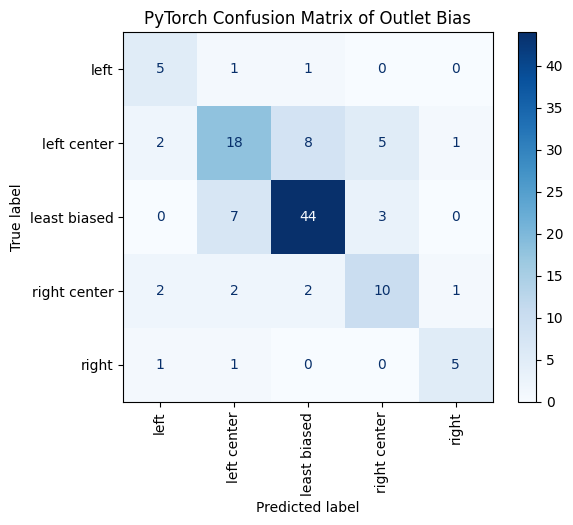

In [12]:
eval_model(tabular_model,model_name="PyTorch",save=True)

## Load Model from Checkpoint

In [13]:
# load_model
#model = MyLightningModule.load_from_checkpoint("/path/to/checkpoint.ckpt")